In [203]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

### Data

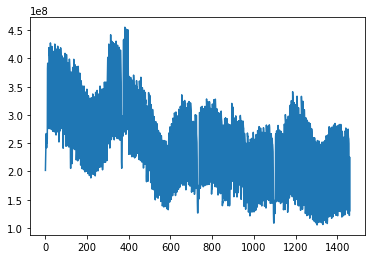

In [204]:
training_set = pd.read_csv('data/train.csv')
val_set = pd.read_csv('data/derived.csv')

training_set = pd.concat([training_set, val_set])

training_set = training_set.iloc[:,1:2].values
# val_set = val_set.iloc[:,1:2].values

plt.plot(training_set, label = 'Shampoo Sales Data')
plt.show()

In [270]:
training_set

array([[201979088],
       [223095158],
       [233791442],
       ...,
       [122282606],
       [225638432],
       [130522880]])

### Data loading

In [343]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)
    x.append(data[len(data)-seq_length:len(data)])
    y.append(data[len(data) - 1])

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

test_size = 365
train_size = len(y) - test_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:(len(x)+1)])))
testY = Variable(torch.Tensor(np.array(y[train_size:(len(y)+1)])))

# valX = Variable(torch.Tensor(np.array(x_val)))
# valY = Variable(torch.Tensor(np.array(y_val)))

In [344]:
x_n, y_n = sliding_windows(training_set, seq_length)

In [347]:
testY

tensor([[0.0089],
        [0.0724],
        [0.1215],
        [0.1234],
        [0.0745],
        [0.0574],
        [0.0864],
        [0.1836],
        [0.4456],
        [0.4622],
        [0.4204],
        [0.1334],
        [0.1175],
        [0.4757],
        [0.4582],
        [0.4557],
        [0.4452],
        [0.4050],
        [0.1217],
        [0.1386],
        [0.5030],
        [0.4830],
        [0.4704],
        [0.4645],
        [0.4188],
        [0.1173],
        [0.1252],
        [0.4794],
        [0.4602],
        [0.4419],
        [0.4370],
        [0.4082],
        [0.1083],
        [0.1187],
        [0.4732],
        [0.4565],
        [0.4504],
        [0.4404],
        [0.4100],
        [0.1157],
        [0.1174],
        [0.4622],
        [0.4406],
        [0.4333],
        [0.4217],
        [0.3808],
        [0.0767],
        [0.0867],
        [0.4442],
        [0.4577],
        [0.5094],
        [0.4993],
        [0.4271],
        [0.0775],
        [0.1163],
        [0

### Model

In [375]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True) # MAPE = 13.8

        # self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) #14.75

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        ula, (h_out, _) = self.lstm(x, (h_0, c_0)) # MAPE = 13.8
        # ula, h_out = self.gru(x, h_0) #14.75
        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

In [376]:
num_epochs = 3000 # 12.5
# num_epochs = 4000 # 14.5
# learning_rate = 0.03 # 13.5
learning_rate = 0.01 # 12.5
input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)

    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 1.24869
Epoch: 100, loss: 0.04511
Epoch: 200, loss: 0.04180
Epoch: 300, loss: 0.03599
Epoch: 400, loss: 0.02978
Epoch: 500, loss: 0.02483
Epoch: 600, loss: 0.02170
Epoch: 700, loss: 0.01893
Epoch: 800, loss: 0.01641
Epoch: 900, loss: 0.01477
Epoch: 1000, loss: 0.01397
Epoch: 1100, loss: 0.01357
Epoch: 1200, loss: 0.01331
Epoch: 1300, loss: 0.01310
Epoch: 1400, loss: 0.01291
Epoch: 1500, loss: 0.01275
Epoch: 1600, loss: 0.01260
Epoch: 1700, loss: 0.01244
Epoch: 1800, loss: 0.01226
Epoch: 1900, loss: 0.01207
Epoch: 2000, loss: 0.01185
Epoch: 2100, loss: 0.01159
Epoch: 2200, loss: 0.01133
Epoch: 2300, loss: 0.01110
Epoch: 2400, loss: 0.01090
Epoch: 2500, loss: 0.01074
Epoch: 2600, loss: 0.01063
Epoch: 2700, loss: 0.01055
Epoch: 2800, loss: 0.01049
Epoch: 2900, loss: 0.01044


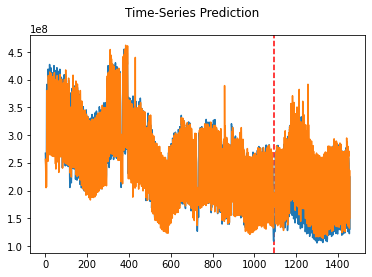

In [377]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [378]:
data_predict[train_size:]

array([[1.96014704e+08],
       [1.72745248e+08],
       [1.79308096e+08],
       [1.83147568e+08],
       [1.84367600e+08],
       [1.70846816e+08],
       [1.73238848e+08],
       [1.82642864e+08],
       [1.99153280e+08],
       [2.30831216e+08],
       [2.68911680e+08],
       [2.43054368e+08],
       [1.39802000e+08],
       [2.51057200e+08],
       [2.80714816e+08],
       [2.66090096e+08],
       [2.69772032e+08],
       [2.20591888e+08],
       [2.06219616e+08],
       [1.36570256e+08],
       [2.60526992e+08],
       [2.77555104e+08],
       [2.75011104e+08],
       [2.70230432e+08],
       [2.25661776e+08],
       [2.06989680e+08],
       [1.39620880e+08],
       [2.67639984e+08],
       [2.77312608e+08],
       [2.67476128e+08],
       [2.61934496e+08],
       [2.21217920e+08],
       [2.09080912e+08],
       [1.33452696e+08],
       [2.60151536e+08],
       [2.74022560e+08],
       [2.65847456e+08],
       [2.67429856e+08],
       [2.19985568e+08],
       [2.09541456e+08],


In [379]:
dataY_plot[train_size:]

array([[1.08624560e+08],
       [1.30814504e+08],
       [1.47999392e+08],
       [1.48669776e+08],
       [1.31564544e+08],
       [1.25601040e+08],
       [1.35721744e+08],
       [1.69704864e+08],
       [2.61277568e+08],
       [2.67081344e+08],
       [2.52466752e+08],
       [1.52145216e+08],
       [1.46600928e+08],
       [2.71796896e+08],
       [2.65683216e+08],
       [2.64796928e+08],
       [2.61155552e+08],
       [2.47076960e+08],
       [1.48054384e+08],
       [1.53973776e+08],
       [2.81360224e+08],
       [2.74340352e+08],
       [2.69932832e+08],
       [2.67876752e+08],
       [2.51921440e+08],
       [1.46534672e+08],
       [1.49293648e+08],
       [2.73101408e+08],
       [2.66381776e+08],
       [2.59995504e+08],
       [2.58272048e+08],
       [2.48194496e+08],
       [1.43388544e+08],
       [1.46994816e+08],
       [2.70926272e+08],
       [2.65083472e+08],
       [2.62968128e+08],
       [2.59472320e+08],
       [2.48832640e+08],
       [1.45965552e+08],


In [380]:
def MAPE(y_true, y_pred):
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), 1e-6)
    mape  = np.average(mape) * 100
    return mape

In [381]:
MAPE(dataY_plot[train_size:], data_predict[train_size:])

16.185982525348663

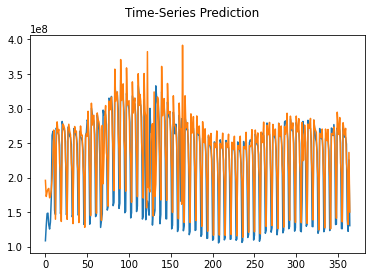

In [382]:
lstm.eval()
train_predict = lstm(testX)

data_predict = train_predict.data.numpy()
dataY_plot = testY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [383]:
MAPE(data_predict, dataY_plot)

11.991807073354721

In [384]:
val_set = pd.read_csv('data/derived.csv')

In [385]:
val_set['date'].iloc[0]

'2019-01-01'

In [386]:
predicted_values = []
with open('data/my_submission.csv', 'wt') as sf:
    print('date,hits', file=sf)

    for i, predict in enumerate(data_predict):
        print(f'{val_set["date"].iloc[i]},{int(predict[0])}', file=sf)

In [387]:
def read_set(file):
    data = pd.read_csv(file)
    data['date'] = pd.to_datetime(data['date'])
    data = data.rename(columns = {'DATE':'date'})
    data = data.rename(columns = {'hits':'value'})
    data = data.set_index('date')
    return data

In [388]:
data_nn_submission = read_set('data/my_submission.csv')
MAPE(dataY_plot, data_nn_submission)

16.18598375728645